In [1]:
import datetime as dt
import  numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [4]:
!pip install keras

In [6]:
!pip install tensorflow

     |████████████████████████████████| 165.2 MB 2.4 MB/s eta 0:00:01    |██████████████████▋             | 96.1 MB 2.7 MB/s eta 0:00:26
     |████████████████████████████████| 3.4 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.1 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 3.1 MB/s eta 0:00:01
  Using cached protobuf-3.13.0-cp38-cp38-macosx_10_9_x86_64.whl (1.3 MB)
     |████████████████████████████████| 127 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 822 kB/s eta 0:00:01
     |████████████████████████████████| 779 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 155 k

In [29]:
import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [30]:
import cv2
from scipy.stats import uniform

In [31]:
from tqdm import tqdm
from glob import glob

In [32]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical

In [33]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [34]:
#!kaggle competitions download -c https://www.kaggle.com/atulyakumar98/test-dataset

In [35]:
#!pip install kaggle-cli

In [36]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
models_dir = os.path.join(cache_dir, 'models')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [28]:
!cp ./input/keras-pretrained-models/xception* ~/.keras/models/
!ls ~/.keras/models

zsh:1: no matches found: ./input/keras-pretrained-models/xception*


In [41]:
base_folder = './input/fire_dataset'
data_folder = './input/fire_dataset/'
train_data_folder = './input/fire_dataset/fire_images'
test_data_folder = './input/fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [42]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 660.94it/s]


In [43]:
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [49]:
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.753.png,0,fire_images
1,fire_images/fire.12.png,0,fire_images
2,fire_images/fire.747.png,0,fire_images
3,fire_images/fire.592.png,0,fire_images
4,fire_images/fire.586.png,0,fire_images


In [50]:
def create_mask_for_fire(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_hsv = np.array([0, 0, 255])
    upper_hsv = np.array([250, 255, 255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

In [51]:
def segment_image(image):
    mask = create_mask_for_fire(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

In [52]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0,0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [53]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size = size)
    img = image.img_to_array(img)
    return img

Text(0.5, 0.98, 'SAMPLE IMAGES')

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

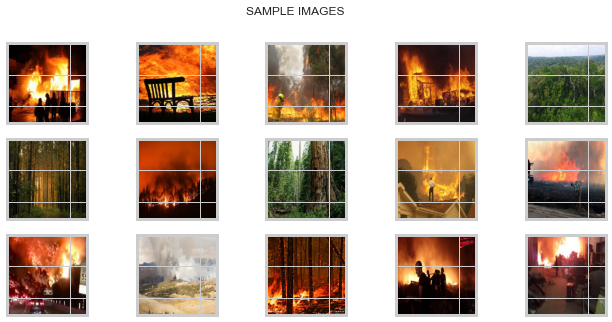

In [56]:
nb_rows = 3
nb_cols = 5
%matplotlib inline

fig, axs = plt.subplots(nb_rows, nb_cols, figsize = (10, 5))
plt.suptitle('SAMPLE IMAGES')

for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([])
        axs[i, j].yaxis.set_ticklabels([])
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255, 255)))/255.);
plt.show()

Text(0.5, 0.8, 'SAMPLE PROCESSED IMAGE')

Text(0.5, 1.0, 'ORIGNAL')

Text(0.5, 1.0, 'MASK')

Text(0.5, 1.0, 'SEGMENTED')

Text(0.5, 1.0, 'SHARPEN')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


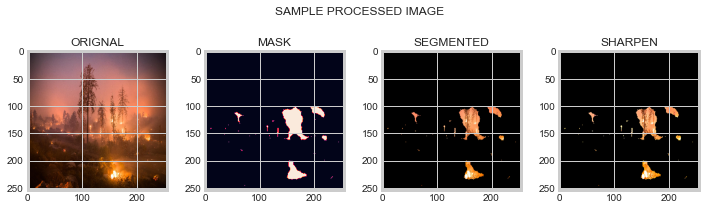

In [59]:
img = read_img(df['file'][102], (255, 255))

image_mask = create_mask_for_fire(img)

image_segmented = segment_image(img)

image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize = (10, 5))
plt.suptitle('SAMPLE PROCESSED IMAGE', x = 0.5, y = 0.8)
plt.tight_layout()

ax[0].set_title('ORIGNAL', fontsize = 12)
ax[1].set_title('MASK', fontsize = 12)
ax[2].set_title('SEGMENTED', fontsize = 12)
ax[3].set_title('SHARPEN', fontsize = 12)

ax[0].imshow(img/255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

In [74]:
INPUT_SIZE = 255

X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype = 'float')

for i, file in tqdm(enumerate(df['file'])):
    
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    
    image_segmented = segment_image(img)
    
    image_sharpen = sharpen_image(image_segmented)
    
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis = 0))
    X_train[i] = x
                   

999it [00:21, 46.48it/s]


In [75]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


In [76]:
## splitting the date
y = df['id']
train_x, val_x, train_y, val_y = train_test_split(X_train, y, test_size = 0.2, random_state = 101)

In [77]:
print('FIRE IMAGES ON TRAINING DATA: ', train_y[train_y == 0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ', train_y[train_y == 1].shape[0])

FIRE IMAGES ON TRAINING DATA:  610
NON-FIRE IMAGES ON TRAINING DATA:  189


In [78]:
xception_bf = xception.Xception(weights='imagenet', include_top = False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size = 32, verbose = 1)
bf_train_val = xception_bf.predict(val_x, batch_size = 32, verbose = 1)

7/7 [==============================] - 6s 900ms/step


In [79]:
print('Train shape: ', bf_train_x.shape)
print('Train size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.size)

Train shape:  (799, 2048)
Train size:  1636352
Validation Shape:  409600


In [80]:
model = Sequential()
model.add(Dense(units = 256, activation = 'relu', input_dim = bf_train_x.shape[1]))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(bf_train_x, train_y, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5357 - accuracy: 0.7635
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4573 - accuracy: 0.7760
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3982 - accuracy: 0.8210
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3838 - accuracy: 0.8160
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3673 - accuracy: 0.8335
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8198
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8373
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3246 - accuracy: 0.8561
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3144 - accuracy: 0.8523
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2991 - accuracy: 0.8773
Epoch 11/

25/25 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.9487
Epoch 84/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9374
Epoch 85/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9374
Epoch 86/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9287
Epoch 87/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.8974
Epoch 88/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9324
Epoch 89/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1560 - accuracy: 0.9337
Epoch 90/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9274
Epoch 91/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9412
Epoch 92/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.9374
Epoch 93/100


Text(0.5, 1.0, 'TRAINING LOSS')

Text(0.5, 1.0, 'TRAINING ACCURACY')

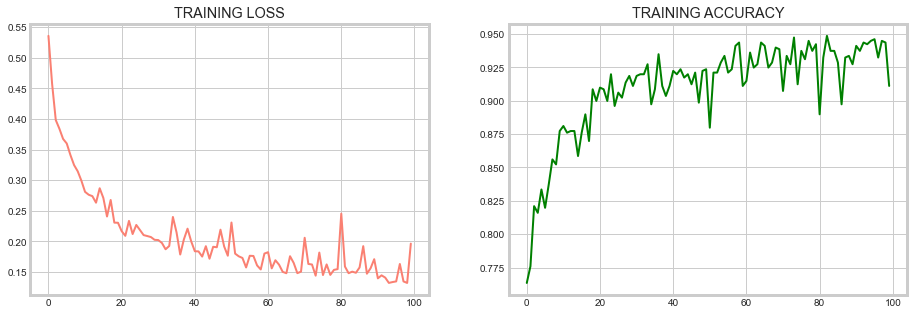

In [82]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
ax[0].set_title('TRAINING LOSS')
ax[1].set_title('TRAINING ACCURACY')

ax[0].plot(history.history['loss'], color = 'salmon', lw = 2)
ax[1].plot(history.history['accuracy'], color = 'green', lw = 2)

In [83]:
predictions = model.predict_classes(bf_train_val)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [85]:
print(classification_report(val_y, predictions))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       145
           1       0.92      0.80      0.85        55

    accuracy                           0.93       200
   macro avg       0.92      0.89      0.90       200
weighted avg       0.92      0.93      0.92       200



<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'CONFUSION MATRIX')

Text(0.5, 94.73999999999998, 'Y_TRUE')

Text(41.099999999999994, 0.5, 'PREDICTIONS')

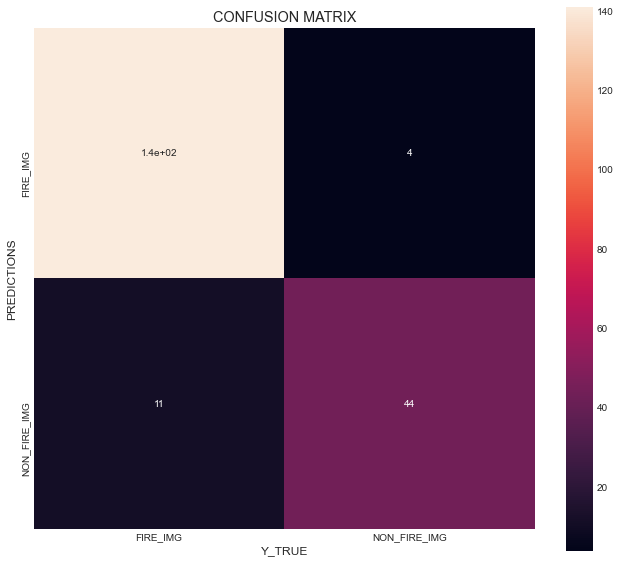

In [89]:
## confusion matrix

confusion_mat = confusion_matrix(val_y, predictions)

plt.figure(figsize = (10, 10))
sns.heatmap(confusion_mat, square = True, annot = True,
           yticklabels = ['FIRE_IMG', 'NON_FIRE_IMG'],
           xticklabels = ['FIRE_IMG', 'NON_FIRE_IMG'])

plt.title('CONFUSION MATRIX')
plt.xlabel('Y_TRUE')
plt.ylabel('PREDICTIONS')